### Make Wave2Web DataFrames

This notebook will make the raw dataframes which can be used to predict reservoir levels. 

**approach**:
- get the geometries of the Pfafstetter Level 12 basins upstream of each reservoir
- use those geometries to query ERA5 weather and ECMWF forecast data and reduce over each upstream geometry
- assemble a full dataframe

In [2]:
import os
from datetime import datetime as dt
import random
import matplotlib.pyplot as plt

import geopandas as gpd # geodataframe manipulation
import networkx as nx   # network traversal
import xarray as xr
import zarr
import gcsfs
import pandas as pd
import numpy as np

import rasterio as rio
from rasterio.features import rasterize
from skimage.measure import block_reduce

# we might want some dask for getting data
import dask
from dask.distributed import Client
client = Client(n_workers=13, threads_per_worker=1, memory_limit='4GB', dashboard_address=':8787')

# ... that's a big bag of tricks

In [ ]:
root = os.getcwd() # set our root directory

In [ ]:
zr = xr.open_zarr()

In [4]:
root = os.path.abspath(os.path.join(os.getcwd(),'..'))

### Get Upstream Geometries of each reservoir

We want to use the directed nature of the Pfafstetter basins to get all the upstream basins for each reservoir. We can use networkx for this.

In [12]:
# load our data
basins = gpd.read_file(os.path.join(root,'wave2web_data','hybas_as_lev12_v1c.shp'))
#reservoirs = gpd.read_file(os.path.join(root,'wave2web_data','reservoirs.shp'))
reservoirs = gpd.read_file(os.path.join(root,'h2ox-reservoirs.geojson'))
ne = gpd.read_file(os.path.join(root,'wave2web_data','ne_10m_countries.gpkg'))   # natural earth so we can sensibly clip to India

In [13]:
# clip our basins to India
india = ne.loc[ne['ADMIN']=='India',:]

In [14]:
basins = basins[basins.intersects(india.geometry.unary_union)]

(11.0, 14.0)

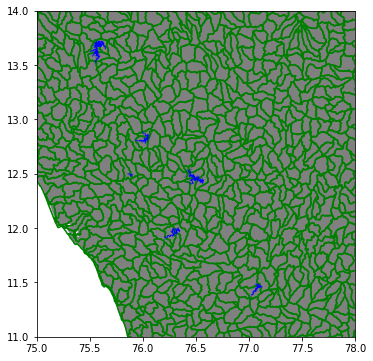

In [17]:
# visualise
fig, ax = plt.subplots(1,1,figsize=(6,6))
india.plot(ax=ax, color='gray', zorder=0)
basins.boundary.plot(ax=ax, color='g', zorder=1)
reservoirs.plot(ax=ax, color='b', zorder=2)
ax.set_xlim([75,78])
ax.set_ylim([11,14])

In [19]:
# set up our directed graph of Level 12 Pfafstetted basins
g = nx.DiGraph()
g.add_edges_from(basins[['HYBAS_ID','NEXT_DOWN']].to_records(index=False).tolist())

In [20]:
# get sources for tree search
reservoirs = reservoirs.set_index('DAM_NAME')

In [21]:
upstream_node_dict = {}
for idx, row in reservoirs.iterrows():
    source_nodes = basins.loc[basins.intersects(row.geometry),'HYBAS_ID'].values.tolist()
    
    upstream_nodes = []
    for sn in source_nodes:
        upstream_nodes += [n for n in nx.traversal.bfs_tree(g, sn, reverse=True) if n != 2]
        
    upstream_node_dict[idx] = list(set(upstream_nodes))   # get unique
    print (idx, 'N source nodes:',len(source_nodes), 'N upstream nodes:',len(upstream_node_dict[idx]))

Bhadra N source nodes: 5 N upstream nodes: 14
Lower Bhawani N source nodes: 5 N upstream nodes: 31
Hemavathy N source nodes: 6 N upstream nodes: 22
Krisharaja Sagar N source nodes: 7 N upstream nodes: 83
Kabini N source nodes: 4 N upstream nodes: 19
Harangi N source nodes: 2 N upstream nodes: 4


In [22]:
upstream_geometries = {}
for kk, vv in upstream_node_dict.items():
    upstream_geometries[kk] = basins.loc[basins['HYBAS_ID'].isin(vv),'geometry'].unary_union

In [23]:
r = lambda: random.randint(0,255) # for random colors

(11.0, 14.0)

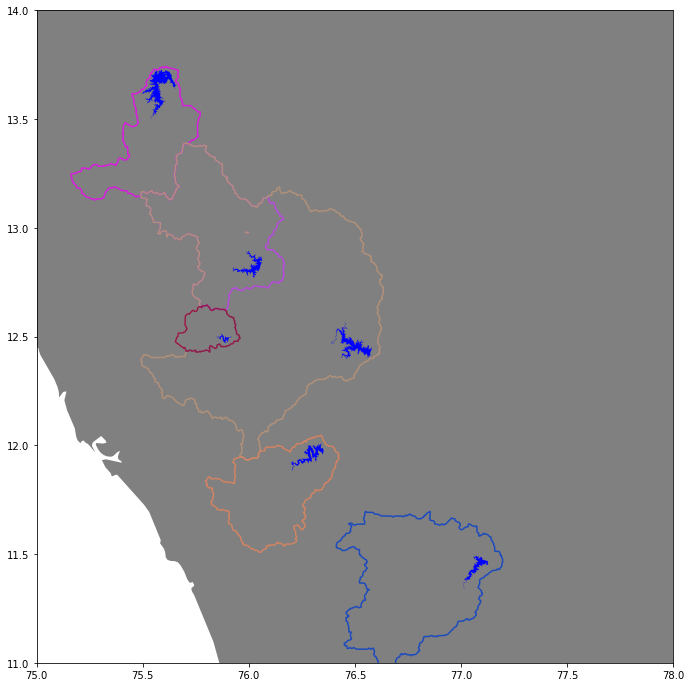

In [25]:
# visualise
fig, ax = plt.subplots(1,1,figsize=(12,12))
india.plot(ax=ax, color='gray')
for kk,vv in upstream_geometries.items():
    gpd.GeoSeries(vv).boundary.plot(ax=ax, color=f'#{r():02x}{r():02x}{r():02x}')
reservoirs.plot(ax=ax, color='b', zorder=2)
ax.set_xlim([75,78])
ax.set_ylim([11,14])

In [27]:
basin_upstream_geoms = gpd.GeoDataFrame(pd.DataFrame([{'dam_name':kk,'geometry':vv} for kk,vv in upstream_geometries.items()]),geometry='geometry')

In [30]:
basin_upstream_geoms.to_file(os.path.join(root,'wave2web_data','upstream_basins.gpkg'))

### Query weather and forecast data for the reservoirs

We have moved a large volume of temperature (t2m) and total precipitation (tp) data to cloud zarr formats. Historic hourly weather data for the period **2010-01-01 - 2020-12-31** has been obtained from ECMWF's ERA5 archive. Daily ensemble 360-hour (15-day) weather forecast model results have also been obtained from ECMWF for the same period (minus an 8 month period of data corruption from 2016-11 through 2017-07. ERA5 historic data has a spatial resolution of 0.1deg; forecast data has a spatial resolution of 0.5deg.

Crucially, the data has been re-chunked along the temporal axis, allowing very fast retrieval of timeseries data.

#### Obtaining Weather Data

In [ ]:
store_era5 = gcsfs.GCSMap(root='oxeo-era5/lk-test-build')

In [ ]:
zr_era5 = xr.open_zarr(store_era5)

In [ ]:
start_idx = (dt.strptime('2010-01-01','%Y-%m-%d') - dt.strptime('1981-01-01','%Y-%m-%d')).days*24

In [ ]:
end_idx = (dt.strptime('2020-12-31','%Y-%m-%d') - dt.strptime('1981-01-01','%Y-%m-%d')).days*24

In [ ]:
time_slice = slice(start_idx, end_idx)

In [ ]:
data = zr_era5['tp'][0:10,800:810,time_slice].values

In [ ]:
data.shape

In [ ]:
plt.plot(data.sum(axis=0).sum(axis=0))

In [ ]:
zr_era5.

For each reservoir geometry we need to get the dataarray. We want to:
- get the slice of the archive that corresponds to our lat, lon, and time window
- multiply this window by a mask for each pixel which corresponds to the coverage of this basin in the data

**Getting the basin mask**

In [31]:
# some helper functions for when we are rounding to non-base 10 (e.g. 0.5deg lat/lon)
def baseround(x, base):
    return base * np.round(x/base)
def basefloor(x, base):
    return base * np.floor(x/base)
def baseceil(x, base):
    return base * np.ceil(x/base)

In [32]:
def get_shape_mask(geom,explode_factor,wgs_resolution):
    """ takes a shapely geometry and returns a numpy array mask of the bounds extents.
    Where pixels aren't full returns the portion of the filled in cell.
    
    Parameters
    ----------
    
    geom: shapely.geometry
        The shapely geometry in wgs84 coordinates to mask
    explode_factor: int
        A resampling factor for the raster, higher gives more precise coverage in non-full, non-empty pixels
    wgs_resolution: float
        The resolution to rasterise in, e.g. for downstream masking tasks.
    """
    
    ### build a big array to burn in
    # get dimensions first
    L = basefloor(geom.bounds[0],wgs_resolution)
    R = baseceil(geom.bounds[2],wgs_resolution)
    B = basefloor(geom.bounds[1], wgs_resolution)
    T = baseceil(geom.bounds[3], wgs_resolution)
    
    big_arr = np.zeros((int(np.round((T-B)/wgs_resolution))*explode_factor, int(np.round((R-L)/wgs_resolution))*explode_factor), dtype=np.uint8)
    
    # build an affine transform for the big array
    affine = rio.transform.from_bounds(L, B, R, T, big_arr.shape[1], big_arr.shape[0])
    
    if geom.type=='Polygon':
        geom_list = [geom]
    elif geom.type=='MultiPolygon':
        geom_list = list(geom)
    
    # burn-in the big array
    rasterize(geom_list, 
              fill=0, 
              default_value = 1,
              out=big_arr, 
              transform=affine, 
    )
    
    # block-reduce and normalise
    ann = block_reduce(big_arr, (explode_factor, explode_factor), np.sum) / explode_factor / explode_factor
    new_affine = rio.transform.from_bounds(L,B,R,T, ann.shape[1], ann.shape[0])
    return ann, new_affine

In [ ]:
basin_data = {}
for kk, geom in upstream_geometries.items():
    
    print (f'Fetching data for {kk}')
    basin_mask, basin_affine = get_shape_mask(
        geom,
        explode_factor=10, # explode to a 10x10 grid to get partially-filled pixels
        wgs_resolution = 0.1 # ERA5 land with a 0.1 deg resolution
    )
    
    # visualise the basin mask
    fig, ax = plt.subplots(1,2,figsize=(6,12))
    gpd.GeoSeries(geom).plot(ax=ax[0])
    ax[1].imshow(basin_mask)
    ax[0].set_title(kk)
    ax[1].set_title('Basin Mask @ 0.1deg')
    plt.show()
    
    # get the data slices
    lon_slice = slice(
        int(np.round((basefloor(geom.bounds[0]+180,0.1)-180)/0.1)),
        int(np.round((baseceil(geom.bounds[2]+180,0.1)-180)/0.1))
    )
    lat_slice = slice(
        int(np.round((180-(baseceil(geom.bounds[3],0.1)+90))/0.1)),
        int(np.round((180-(basefloor(geom.bounds[1],0.1)+90))/0.1)),
    )
    
    # fetch the data from the zarr and operate on it using our dask client
    basin_data_tp = zr_era5['tp'][lon_slice,lat_slice,time_slice].transpose("latitude","longitude","time").groupby("time.date").sum("time").values
    basin_data_t2m = zr_era5['t2m'][lon_slice,lat_slice,time_slice].transpose("latitude","longitude","time").groupby("time.date").mean("time").values
    
    # reduce the resulting 3D timeseries over lat and lon
    basin_data_tp = np.transpose(np.transpose(basin_data_tp,[2,0,1]) * basin_mask,[1,2,0]).sum(axis=0).sum(axis=0)/basin_mask.sum()
    basin_data_t2m = np.transpose(np.transpose(basin_data_t2m,[2,0,1]) * basin_mask,[1,2,0]).sum(axis=0).sum(axis=0)/basin_mask.sum()
    
    basin_data[kk] = {
        'tp':basin_data_tp,
        't2m':basin_data_t2m
    }

In [ ]:
# cast our data to a pandas dataframe
dfs = {}
for kk, vv in basin_data.items():
    dfs[kk] = pd.DataFrame(
        index = pd.date_range(start='2010-01-01', end='2020-12-30', freq='1D'),
        data = vv
    )

In [ ]:
color_dict = {kk:f'#{r():02x}{r():02x}{r():02x}' for kk in basin_data.keys()}

In [ ]:
# visualise
fig, axs = plt.subplots(2,1,figsize=(12,6))
for kk, df in dfs.items():
    df[['tp']].rename(columns={'tp':kk}).plot(ax=axs[0], color=color_dict[kk])
    df[['t2m']].rename(columns={'t2m':kk}).plot(ax=axs[1], color=color_dict[kk])
axs[0].set_ylabel('tp'), axs[1].set_ylabel('t2m');

### Join to reservoir data

In [ ]:
file_paths = {
    'Hemavathy':os.path.join(root,'wave2web_data','Hemavathi.csv'),
    'Kabini':os.path.join(root,'wave2web_data','kabini.csv'),
    'Harangi':os.path.join(root,'wave2web_data','Harangi.csv'),
    'Krisharaja Sagar':os.path.join(root,'wave2web_data','KRS.csv'),
}
keep_columns = ['FLOW_DATE','PRESENT_STORAGE_TMC','RES_LEVEL_FT','INFLOW_CUSECS','OUTFLOW_CUECS']

In [ ]:
pd.merge(dfs['Harangi'],reservoir_df.set_index('FLOW_DATE'), how='left',left_index=True, right_index=True)

In [ ]:
def try_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [ ]:
for kk in dfs.keys():
    reservoir_df = pd.read_csv(file_paths[kk])
    reservoir_df['FLOW_DATE'] = pd.to_datetime(reservoir_df['FLOW_DATE'])
    for column in ['RES_LEVEL_FT','INFLOW_CUSECS']:
        reservoir_df[column] = reservoir_df[column].str.strip().apply(try_float)
    
    dfs[kk] = pd.merge(
        dfs[kk],
        reservoir_df[keep_columns].set_index('FLOW_DATE'),
        how='left',
        left_index=True,
        right_index=True,
    )
    dfs[kk].to_csv(os.path.join(root,'wave2web_data',kk+'_interim.csv'))

In [ ]:
# visualise
fig, axs = plt.subplots(4,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp']].plot(ax=axs[ii_k][0], color=color_dict[kk])
    df[['RES_LEVEL_FT']].plot(ax=axs[ii_k][0], secondary_y='RES_LEVEL_FT', color='k')
    df[['t2m']].plot(ax=axs[ii_k][1], color=color_dict[kk])
    df[['RES_LEVEL_FT']].plot(ax=axs[ii_k][1], secondary_y='RES_LEVEL_FT', color='k')
    axs[ii_k][0].set_ylabel(kk)
plt.show()

### Obtaining Forecast Data

In [33]:
store_forecast = gcsfs.GCSMap(root='oxeo-forecasts/ecmwf-forecast')

In [34]:
zr_forecast = xr.open_zarr(store_forecast)

doing Bhadra


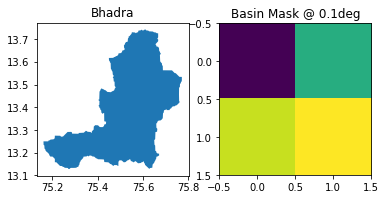

doing Lower Bhawani


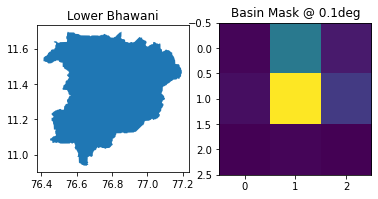

doing Hemavathy


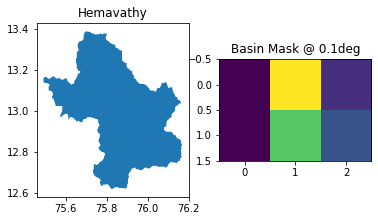

doing Krisharaja Sagar


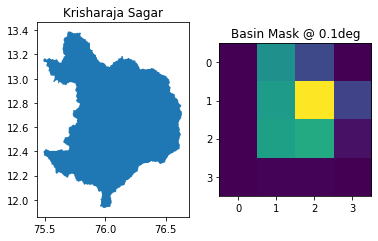

doing Kabini


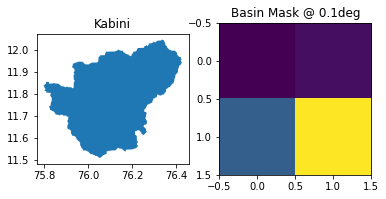

doing Harangi


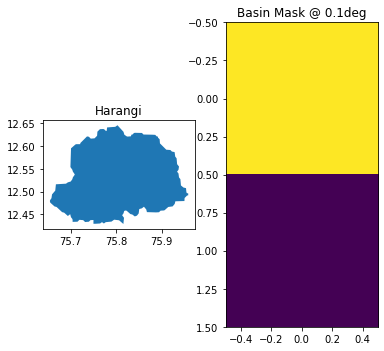

In [45]:
forecast_data = {}
for kk, geom in upstream_geometries.items():
    
    print (f'doing {kk}')
    basin_mask, basin_affine = get_shape_mask(
        geom,
        explode_factor=10, # explode to a 10x10 grid to get partially-filled pixels
        wgs_resolution = 0.5 # ERA5 land with a 0.1 deg resolution
    )
    
    # visualise the basin mask
    fig, ax = plt.subplots(1,2,figsize=(6,12))
    gpd.GeoSeries(geom).plot(ax=ax[0])
    ax[1].imshow(basin_mask)
    ax[0].set_title(kk)
    ax[1].set_title('Basin Mask @ 0.1deg')
    plt.show()
    
    # get the data slices
    lon_slice = slice(
        int(np.round((basefloor(geom.bounds[0]+180,0.5)-180)/0.5)),
        int(np.round((baseceil(geom.bounds[2]+180,0.5)-180)/0.5))
    )
    lat_slice = slice(
        int(np.round((180-(baseceil(geom.bounds[3],0.5)+90))/0.5)),
        int(np.round((180-(basefloor(geom.bounds[1],0.5)+90))/0.5)),
    )
    
    end_idx = (dt.strptime('2021-09-11','%Y-%m-%d') - dt.strptime('2010-01-01','%Y-%m-%d')).days
    start_idx = (dt.strptime('2010-01-01','%Y-%m-%d') - dt.strptime('2010-01-01','%Y-%m-%d')).days
    for_time_slice = slice(start_idx,end_idx)
    step_slice = slice(0,61)
    
    data_tp = zr_forecast['tp'][lon_slice, lat_slice, for_time_slice, step_slice].values
    data_t2m = zr_forecast['t2m'][lon_slice, lat_slice, for_time_slice, step_slice].values
    
    data_tp = np.transpose(np.transpose(data_tp,[2,3,1,0]) * basin_mask, [3,2,0,1])
    data_t2m = np.transpose(np.transpose(data_t2m,[2,3,1,0]) * basin_mask, [3,2,0,1])
    
    data_tp = block_reduce(data_tp.sum(axis=0).sum(axis=0)/basin_mask.sum(), (1,4), np.sum)
    data_t2m = block_reduce(data_t2m.sum(axis=0).sum(axis=0)/basin_mask.sum(), (1,4), np.mean)
    
    forecast_data[kk] = {
        'tp':data_tp,
        't2m':data_t2m
    }

In [46]:
forecast_data['Bhadra']['tp'].shape

(4271, 16)

In [48]:
[kk.lower().replace(' ','_') for kk in forecast_data.keys()]

['bhadra',
 'lower_bhawani',
 'hemavathy',
 'krisharaja_sagar',
 'kabini',
 'harangi']

In [44]:
forecast_data.keys()

dict_keys(['Bhadra', 'Lower Bhawani', 'Hemavathy', 'Krisharaja Sagar', 'Kabini', 'Harangi'])

In [51]:
forecast_dfs = {}
for kk, vv in forecast_data.items():
    forecast_dfs[kk] = pd.DataFrame(
        index = pd.date_range(start='2010-01-01', end='2021-09-10', freq='1D'),
        data = np.concatenate([vv['tp'],vv['t2m']], axis=1),
        columns = [f'tp_{ii}' for ii in range(16)] + [f't2m_{ii}' for ii in range(16)]
    ).drop(columns=['tp_15','t2m_15'])

In [ ]:
existing_data = {kk:pd.read_csv(os.path.join(root,'wave2web_data',f'{kk}_interim.csv')).set_index('Unnamed: 0') for kk in forecast_dfs.keys()}

In [ ]:
for kk in existing_data.keys():
    existing_data[kk].index = pd.to_datetime(existing_data[kk].index)

In [ ]:
merged_data = {}
for kk in existing_data.keys():
    merged_data[kk]= pd.merge(
        existing_data[kk],
        forecast_dfs[kk],
        how='left',
        left_index=True,
        right_index=True,
    )

In [ ]:
for kk, df in merged_data.items():
    df.to_csv(os.path.join(root,'wave2web_data',f'{kk}_w_forecast.csv'))

In [ ]:
merged_data['Hemavathy'].loc[~merged_data['Hemavathy']['PRESENT_STORAGE_TMC'].isna(),:].iloc[0:50]

In [68]:
import json

In [69]:
json.loads(forecast_dfs['Hemavathy'].loc['2010-01-01',:].to_json())

{'tp_0': 6.2119524947,
 'tp_1': 14.8399274594,
 'tp_2': 14.8509551432,
 'tp_3': 14.8592974226,
 'tp_4': 14.8505756699,
 'tp_5': 14.8613440968,
 'tp_6': 14.8771453572,
 'tp_7': 14.8781766802,
 'tp_8': 14.9219377464,
 'tp_9': 21.6625354802,
 'tp_10': 22.9915606062,
 'tp_11': 23.657720548,
 'tp_12': 26.8942602995,
 'tp_13': 31.3438583802,
 'tp_14': 32.8842687874,
 't2m_0': 296.6087911018,
 't2m_1': 295.4653768094,
 't2m_2': 293.90018456,
 't2m_3': 293.7236905677,
 't2m_4': 294.445334176,
 't2m_5': 294.3200991622,
 't2m_6': 293.9617919922,
 't2m_7': 294.0922644071,
 't2m_8': 295.3431832857,
 't2m_9': 294.9234184907,
 't2m_10': 296.1108354943,
 't2m_11': 297.0028083302,
 't2m_12': 296.1818083291,
 't2m_13': 296.2458916067,
 't2m_14': 296.6872902273}

In [59]:
from google.cloud import bigquery

In [60]:
client = bigquery.Client()

In [64]:
table_name = 'oxeo-main.wave2web.forecast'

In [70]:
for reservoir, df in forecast_dfs.items():
    print (reservoir.lower().replace(' ','_'))
    
    entries = []
    for idx, row in df.iterrows():
        
        dd = json.loads(row.to_json())
        dd['reservoir'] = reservoir.lower().replace(' ','_')
        dd['date'] = idx.isoformat()[0:10]
        entries.append(dd)       
    
    errors = client.insert_rows_json(table_name,entries)
    print ('done entries',len(entries))

bhadra
done entries 4271
lower_bhawani
done entries 4271
hemavathy
done entries 4271
krisharaja_sagar
done entries 4271
kabini
done entries 4271
harangi
done entries 4271
